# Predicting Titanic Survival Chance with MLP

## Peter Mervart, Michal Lüley

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.preprocessing import *
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
df_titanic = pd.read_csv("titanic_dataset.csv", sep=";")
df_titanic

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


### Change of column names

In [4]:
df_titanic.rename(columns={'Siblings/Spouses Aboard': 'sib_spous', 'Parents/Children Aboard': 'par_chil', 'Pclass': 'class', 'Sex': 'sex', 'Age': 'age', 'Fare': 'fare', 'Name': 'title', 'Survived': 'survived'}, inplace=True)

### Separating title from name

Mlle is french equivalent of Miss.

Mme is french equivalent of Mrs.

In [5]:
df_titanic['title'] = df_titanic['title'].str.split('.', expand=True)[0]
df_titanic['title'].replace({'Mlle': 'Miss', 'Mme': 'Mrs'}, inplace=True)
print(df_titanic['title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Ms' 'Major' 'Lady' 'Sir'
 'Col' 'Capt' 'the Countess' 'Jonkheer']


### Encoding data

In [6]:
le_sex = LabelEncoder()
le_sex.fit(df_titanic['sex'])
df_titanic['sex']=le_sex.transform(df_titanic['sex'])

le_title = LabelEncoder()
le_title.fit(df_titanic['title'])
df_titanic['title']=le_title.transform(df_titanic['title'])

In [7]:
df_titanic

,survived,class,title,sex,age,sib_spous,par_chil,fare
0,0,3,9,1,22.0,1,0,7.2500
1,1,1,10,0,38.0,1,0,71.2833
2,1,3,8,0,26.0,0,0,7.9250
3,1,1,10,0,35.0,1,0,53.1000
4,0,3,9,1,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,12,1,27.0,0,0,13.0000
883,1,1,8,0,19.0,0,0,30.0000
884,0,3,8,0,7.0,1,2,23.4500
885,1,1,9,1,26.0,0,0,30.0000


## EDA (Raw data)

<Axes: xlabel='title', ylabel='Density'>

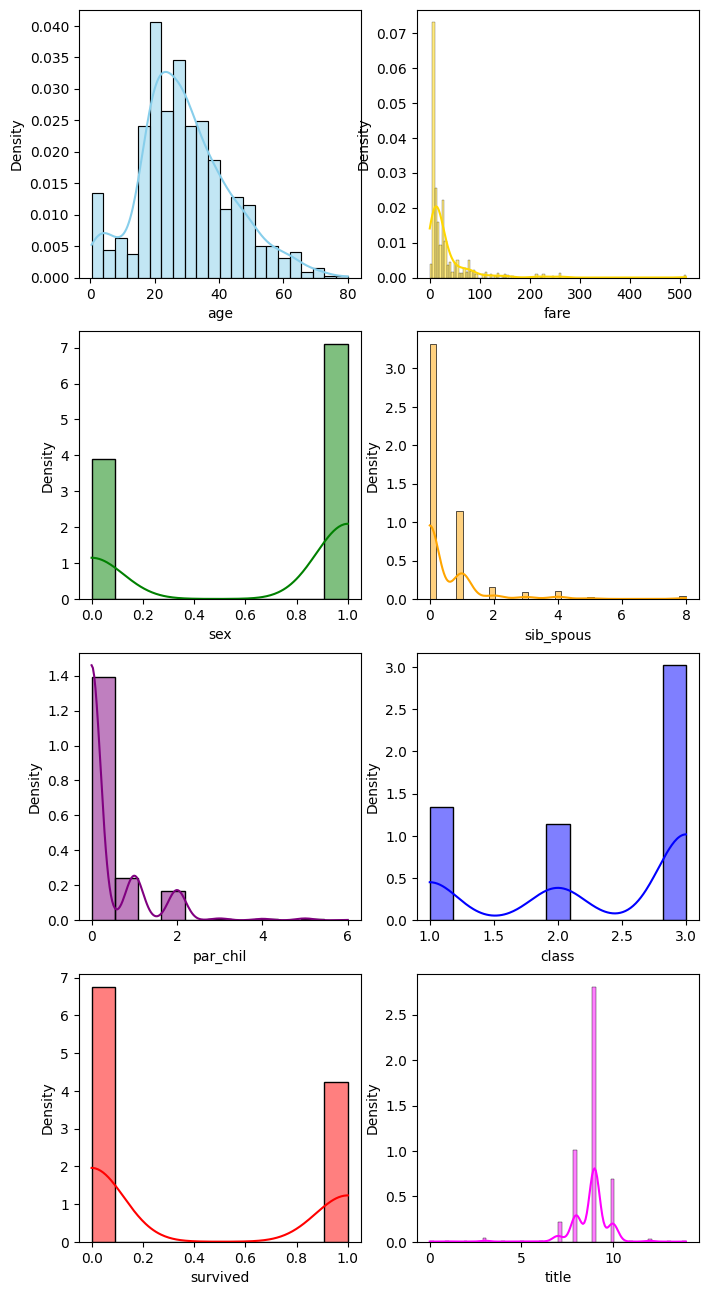

In [8]:
fig, axs = plt.subplots(4, 2, figsize=(8, 16))
sns.histplot(data=df_titanic["age"], stat="density", kde=True, color="skyblue", ax=axs[0,0])
sns.histplot(data=df_titanic["fare"], stat="density", kde=True, color="gold", ax=axs[0,1])
sns.histplot(data=df_titanic["sex"], stat="density", kde=True, color="green", ax=axs[1,0])
sns.histplot(data=df_titanic["sib_spous"], stat="density", kde=True, color="orange", ax=axs[1,1])
sns.histplot(data=df_titanic["par_chil"], stat="density", kde=True, color="purple", ax=axs[2,0])
sns.histplot(data=df_titanic["class"], stat="density", kde=True, color="blue", ax=axs[2,1])
sns.histplot(data=df_titanic["survived"], stat="density", kde=True, color="red", ax=axs[3,0])
sns.histplot(data=df_titanic["title"], stat="density", kde=True, color="magenta", ax=axs[3,1])


## Data augmentation

In [9]:
def dataframe_augmentate(df: pd.DataFrame, min_value= 0.9, max_value= 1.1, mode="scaling", augm_cols=["fare", "age"]) -> pd.DataFrame:
    new_samples = np.zeros(shape=np.shape(df_titanic))

    for row_orig in df_titanic.iterrows():
        row_scaled = row_orig[1].copy()
        
        for augm_col in augm_cols:
            random_value = random.uniform(min_value, max_value)
            if mode == "scaling":
                row_scaled[augm_col] = row_scaled[augm_col]*random_value
            elif mode == "translation":
                row_scaled[augm_col] = row_scaled[augm_col]+random_value
            else:
                print("mode is not available")

        new_samples[row_orig[0]] = row_scaled.values

    return pd.DataFrame(new_samples, columns=list(df_titanic.columns))

## Transformations

In [10]:
def transform_data(df: pd.DataFrame, modifier_type: str, columns: list) -> pd.DataFrame:
    modifier = None
    data_frame = df.copy()
    if modifier_type == "MinMaxScaler":
        modifier = MinMaxScaler(feature_range = (1,2))
    elif modifier_type == "StandardScaler":
        modifier = StandardScaler()
    elif modifier_type == "RobustScaler":
        modifier = RobustScaler()
    elif modifier_type == "PowerTransformer":
        modifier = PowerTransformer(method='yeo-johnson')
    elif modifier_type == "QuantileTransformer":
        modifier = QuantileTransformer(n_quantiles=10, random_state=0)
    data_frame[[*columns]] = modifier.fit_transform(data_frame[[*columns]])
    return data_frame

## Choosing columns

In [11]:
df_titanic.corr(method='pearson')

,survived,class,title,sex,age,sib_spous,par_chil,fare
survived,1.000000,-0.336528,-0.043088,-0.542152,-0.059665,-0.037082,0.080097,0.256179
class,-0.336528,1.000000,0.028524,0.129507,-0.391492,0.085026,0.020252,-0.548919
title,-0.043088,0.028524,1.000000,-0.019303,0.201625,-0.140673,-0.045419,-0.029922
sex,-0.542152,0.129507,-0.019303,1.000000,0.091875,-0.113249,-0.244337,-0.181137
age,-0.059665,-0.391492,0.201625,0.091875,1.000000,-0.297669,-0.193741,0.112329
sib_spous,-0.037082,0.085026,-0.140673,-0.113249,-0.297669,1.000000,0.414244,0.158839
par_chil,0.080097,0.020252,-0.045419,-0.244337,-0.193741,0.414244,1.000000,0.215470
fare,0.256179,-0.548919,-0.029922,-0.181137,0.112329,0.158839,0.215470,1.000000


In [12]:
df_titanic = df_titanic.astype({"class": np.float64, "title": np.float64, "sex": np.float64, "sib_spous": np.float64, "par_chil": np.float64})

### Dividing dataset to train and test

In [13]:
df_titanic = pd.concat([dataframe_augmentate(df_titanic, mode="scaling"), df_titanic], ignore_index = True)

In [14]:
data_X = df_titanic.drop(columns = ['survived']).copy()
data_y = df_titanic['survived']

X, X_test, y, y_test = train_test_split(data_X, data_y, train_size=0.9, random_state=1)

print(X.shape), print(y.shape)
print(X_test.shape), print(y_test.shape)

(1596, 7)
(1596,)
(178, 7)
(178,)


(None, None)

### Dataset transformation

Choosing columns to apply scaler and transformator.

In [16]:
white_list = ["fare", "age", "sib_spous", "par_chil", "class", "title"]

In [17]:
dataset_pipeline = Pipeline([("scaler", FunctionTransformer(transform_data, kw_args={'modifier_type': "RobustScaler", 'columns': white_list})), ("power_transformer", FunctionTransformer(transform_data, kw_args={'modifier_type': "PowerTransformer", 'columns': white_list}))])

In [18]:
X = dataset_pipeline.fit_transform(X)

In [19]:
X_test = dataset_pipeline.fit_transform(X_test)

### Features after normalization

<Axes: xlabel='title', ylabel='Density'>

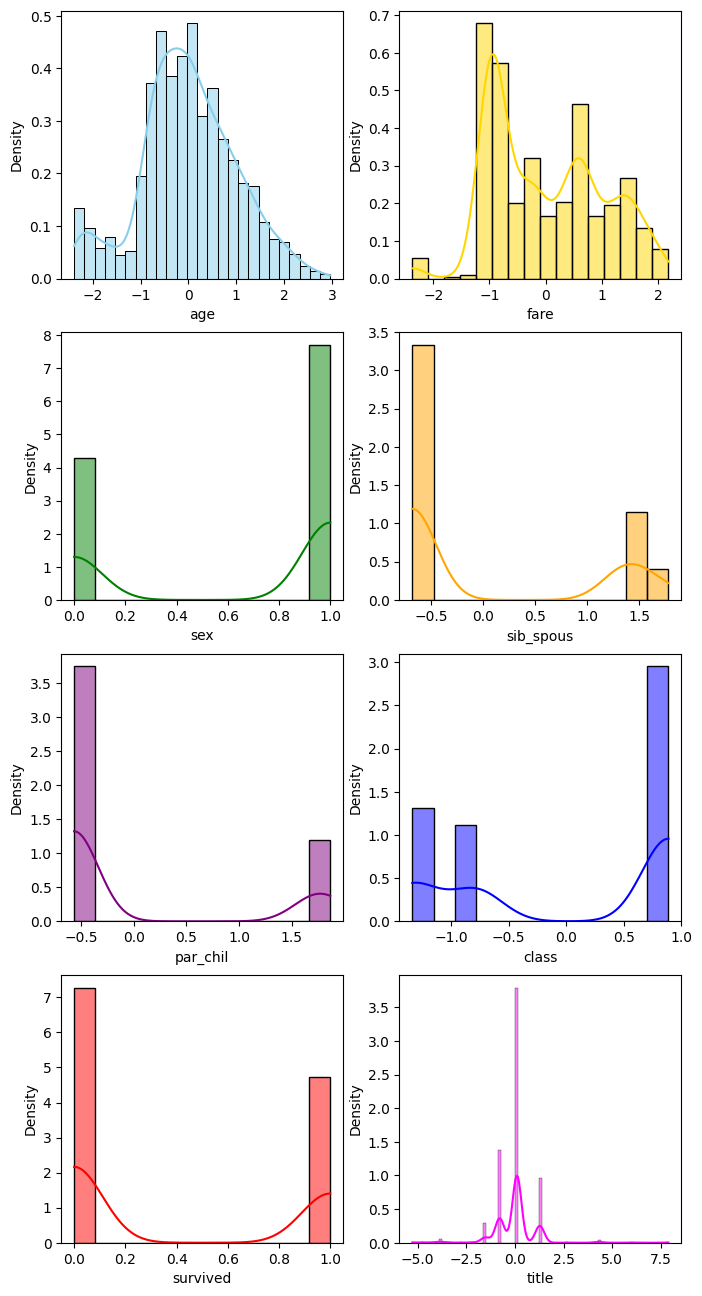

In [20]:
fig, axs = plt.subplots(4, 2, figsize=(8, 16))
sns.histplot(data=X["age"], stat="density", kde=True, color="skyblue", ax=axs[0,0])
sns.histplot(data=X["fare"], stat="density", kde=True, color="gold", ax=axs[0,1])
sns.histplot(data=X["sex"], stat="density", kde=True, color="green", ax=axs[1,0])
sns.histplot(data=X["sib_spous"], stat="density", kde=True, color="orange", ax=axs[1,1])
sns.histplot(data=X["par_chil"], stat="density", kde=True, color="purple", ax=axs[2,0])
sns.histplot(data=X["class"], stat="density", kde=True, color="blue", ax=axs[2,1])
sns.histplot(data=y, stat="density", kde=True, color="red", ax=axs[3,0])
sns.histplot(data=X["title"], stat="density", kde=True, color="magenta", ax=axs[3,1])

### Setting up the tensor flow model

In [21]:
def create_model(lr):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(7, )),
    tf.keras.layers.Dense(8, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(8, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])

    model.compile(optimizer='nadam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

    model.optimizer.lr.assign(lr)
    
    return model

### Early stopping and checkpoint

In [22]:
def get_callbacks(patience, checkpoint_filepath):
    es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience = patience)

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='accuracy',
        mode='max',
        save_best_only=True)
    
    return [es, checkpoint]

### Training and testing the model (cross validation)

Epoch 1/1000
89/89 [==============================] - 1s 1ms/step - loss: 0.6551 - accuracy: 0.5853
Epoch 2/1000
89/89 [==============================] - 0s 912us/step - loss: 0.5981 - accuracy: 0.6862
Epoch 3/1000
89/89 [==============================] - 0s 928us/step - loss: 0.5627 - accuracy: 0.7116
Epoch 4/1000
89/89 [==============================] - 0s 898us/step - loss: 0.5377 - accuracy: 0.7250
Epoch 5/1000
89/89 [==============================] - 0s 909us/step - loss: 0.5110 - accuracy: 0.7602
Epoch 6/1000
89/89 [==============================] - 0s 1ms/step - loss: 0.5083 - accuracy: 0.7694
Epoch 7/1000
89/89 [==============================] - 0s 687us/step - loss: 0.4960 - accuracy: 0.7687
Epoch 8/1000
89/89 [==============================] - 0s 871us/step - loss: 0.4782 - accuracy: 0.7821
Epoch 9/1000
89/89 [==============================] - 0s 933us/step - loss: 0.4783 - accuracy: 0.7842
Epoch 10/1000
89/89 [==============================] - 0s 885us/step - loss: 0.4662 - 

89/89 [==============================] - 0s 659us/step - loss: 0.4210 - accuracy: 0.8173
Epoch 81/1000
89/89 [==============================] - 0s 670us/step - loss: 0.4190 - accuracy: 0.8272
Epoch 82/1000
89/89 [==============================] - 0s 671us/step - loss: 0.4190 - accuracy: 0.8202
Epoch 83/1000
89/89 [==============================] - 0s 670us/step - loss: 0.4247 - accuracy: 0.8237
Epoch 84/1000
89/89 [==============================] - 0s 677us/step - loss: 0.4224 - accuracy: 0.8272
Epoch 85/1000
89/89 [==============================] - 0s 659us/step - loss: 0.4230 - accuracy: 0.8251
Epoch 86/1000
89/89 [==============================] - 0s 675us/step - loss: 0.4307 - accuracy: 0.8223
Epoch 87/1000
89/89 [==============================] - 0s 667us/step - loss: 0.4159 - accuracy: 0.8293
Epoch 88/1000
89/89 [==============================] - 0s 912us/step - loss: 0.4139 - accuracy: 0.8364
Epoch 89/1000
89/89 [==============================] - 0s 673us/step - loss: 0.4321 - a

89/89 [==============================] - 0s 695us/step - loss: 0.4226 - accuracy: 0.8322
Epoch 160/1000
89/89 [==============================] - 0s 738us/step - loss: 0.4100 - accuracy: 0.8279
Epoch 161/1000
89/89 [==============================] - 0s 671us/step - loss: 0.4167 - accuracy: 0.8265
Epoch 162/1000
89/89 [==============================] - 0s 675us/step - loss: 0.4209 - accuracy: 0.8258
Epoch 163/1000
89/89 [==============================] - 0s 677us/step - loss: 0.4104 - accuracy: 0.8307
Epoch 164/1000
89/89 [==============================] - 0s 670us/step - loss: 0.4143 - accuracy: 0.8202
Epoch 165/1000
89/89 [==============================] - 0s 659us/step - loss: 0.4076 - accuracy: 0.8244
Epoch 166/1000
89/89 [==============================] - 0s 664us/step - loss: 0.4155 - accuracy: 0.8300
Epoch 167/1000
89/89 [==============================] - 0s 677us/step - loss: 0.4073 - accuracy: 0.8300
Epoch 168/1000
89/89 [==============================] - 0s 665us/step - loss: 0

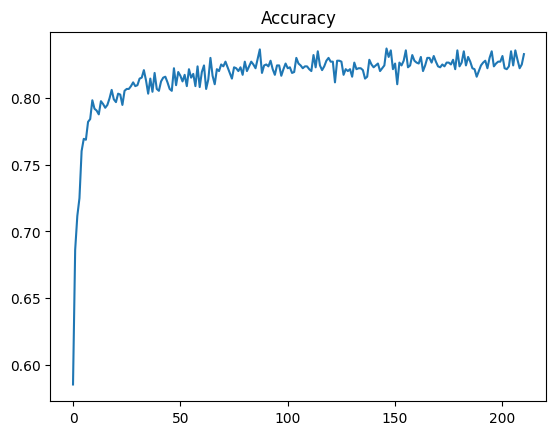

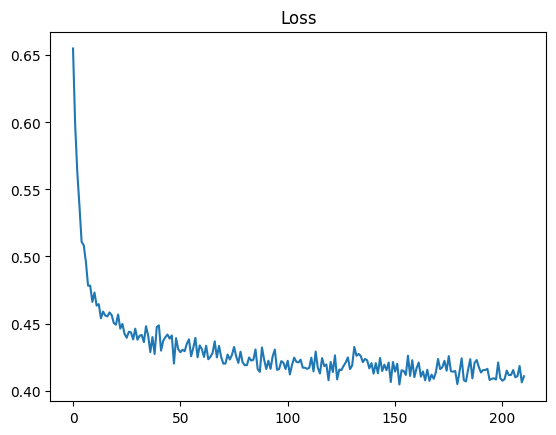

Epoch 1/1000
89/89 [==============================] - 1s 1ms/step - loss: 0.6798 - accuracy: 0.6086
Epoch 2/1000
89/89 [==============================] - 0s 884us/step - loss: 0.6380 - accuracy: 0.6530
Epoch 3/1000
89/89 [==============================] - 0s 900us/step - loss: 0.5957 - accuracy: 0.6946
Epoch 4/1000
89/89 [==============================] - 0s 897us/step - loss: 0.5781 - accuracy: 0.7243
Epoch 5/1000
89/89 [==============================] - 0s 884us/step - loss: 0.5494 - accuracy: 0.7341
Epoch 6/1000
89/89 [==============================] - 0s 887us/step - loss: 0.5377 - accuracy: 0.7384
Epoch 7/1000
89/89 [==============================] - 0s 885us/step - loss: 0.5207 - accuracy: 0.7482
Epoch 8/1000
89/89 [==============================] - 0s 875us/step - loss: 0.4987 - accuracy: 0.7630
Epoch 9/1000
89/89 [==============================] - 0s 884us/step - loss: 0.4986 - accuracy: 0.7638
Epoch 10/1000
89/89 [==============================] - 0s 980us/step - loss: 0.4946 

89/89 [==============================] - 0s 683us/step - loss: 0.4334 - accuracy: 0.8272
Epoch 81/1000
89/89 [==============================] - 0s 686us/step - loss: 0.4251 - accuracy: 0.8244
Epoch 82/1000
89/89 [==============================] - 0s 694us/step - loss: 0.4326 - accuracy: 0.8230
Epoch 83/1000
89/89 [==============================] - 0s 676us/step - loss: 0.4335 - accuracy: 0.8166
Epoch 84/1000
89/89 [==============================] - 0s 680us/step - loss: 0.4297 - accuracy: 0.8195
Epoch 85/1000
89/89 [==============================] - 0s 671us/step - loss: 0.4351 - accuracy: 0.8138
Epoch 86/1000
89/89 [==============================] - 0s 687us/step - loss: 0.4322 - accuracy: 0.8209
Epoch 87/1000
89/89 [==============================] - 0s 671us/step - loss: 0.4312 - accuracy: 0.8159
Epoch 88/1000
89/89 [==============================] - 0s 686us/step - loss: 0.4273 - accuracy: 0.8244
Epoch 89/1000
89/89 [==============================] - 0s 689us/step - loss: 0.4193 - a

89/89 [==============================] - 0s 676us/step - loss: 0.4362 - accuracy: 0.8258
Epoch 160/1000
89/89 [==============================] - 0s 676us/step - loss: 0.4167 - accuracy: 0.8216
Epoch 161/1000
89/89 [==============================] - 0s 687us/step - loss: 0.4213 - accuracy: 0.8272
Epoch 162/1000
89/89 [==============================] - 0s 676us/step - loss: 0.4162 - accuracy: 0.8251
Epoch 163/1000
89/89 [==============================] - 0s 682us/step - loss: 0.4278 - accuracy: 0.8181
Epoch 164/1000
89/89 [==============================] - 0s 677us/step - loss: 0.4212 - accuracy: 0.8251
Epoch 165/1000
89/89 [==============================] - 0s 686us/step - loss: 0.4165 - accuracy: 0.8223
Epoch 166/1000
89/89 [==============================] - 0s 682us/step - loss: 0.4229 - accuracy: 0.8286
Epoch 167/1000
89/89 [==============================] - 0s 688us/step - loss: 0.4149 - accuracy: 0.8216
Epoch 168/1000
89/89 [==============================] - 0s 671us/step - loss: 0

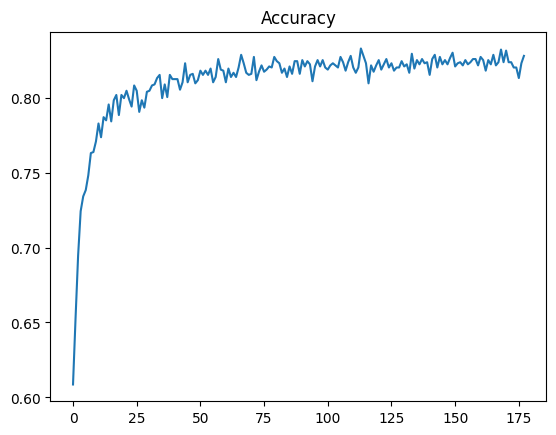

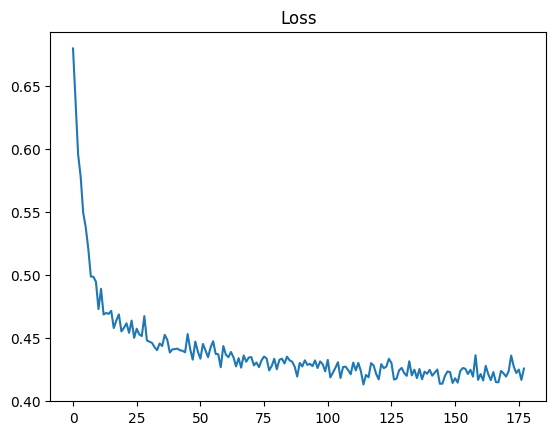

Epoch 1/1000
89/89 [==============================] - 1s 897us/step - loss: 0.6705 - accuracy: 0.6213
Epoch 2/1000
89/89 [==============================] - 0s 932us/step - loss: 0.6366 - accuracy: 0.6544
Epoch 3/1000
89/89 [==============================] - 0s 881us/step - loss: 0.6271 - accuracy: 0.6721
Epoch 4/1000
89/89 [==============================] - 0s 873us/step - loss: 0.6045 - accuracy: 0.6763
Epoch 5/1000
89/89 [==============================] - 0s 876us/step - loss: 0.5840 - accuracy: 0.7038
Epoch 6/1000
89/89 [==============================] - 0s 881us/step - loss: 0.5649 - accuracy: 0.7080
Epoch 7/1000
89/89 [==============================] - 0s 882us/step - loss: 0.5309 - accuracy: 0.7384
Epoch 8/1000
89/89 [==============================] - 0s 889us/step - loss: 0.5048 - accuracy: 0.7630
Epoch 9/1000
89/89 [==============================] - 0s 895us/step - loss: 0.4951 - accuracy: 0.7687
Epoch 10/1000
89/89 [==============================] - 0s 904us/step - loss: 0.494

89/89 [==============================] - 0s 654us/step - loss: 0.4078 - accuracy: 0.8286
Epoch 81/1000
89/89 [==============================] - 0s 655us/step - loss: 0.4258 - accuracy: 0.8138
Epoch 82/1000
89/89 [==============================] - 0s 658us/step - loss: 0.4234 - accuracy: 0.8258
Epoch 83/1000
89/89 [==============================] - 0s 683us/step - loss: 0.4274 - accuracy: 0.8251
Epoch 84/1000
89/89 [==============================] - 0s 652us/step - loss: 0.4165 - accuracy: 0.8188
Epoch 85/1000
89/89 [==============================] - 0s 663us/step - loss: 0.4171 - accuracy: 0.8173
Epoch 86/1000
89/89 [==============================] - 0s 654us/step - loss: 0.4218 - accuracy: 0.8166
Epoch 87/1000
89/89 [==============================] - 0s 664us/step - loss: 0.4168 - accuracy: 0.8272
Epoch 88/1000
89/89 [==============================] - 0s 649us/step - loss: 0.4276 - accuracy: 0.8209
Epoch 89/1000
89/89 [==============================] - 0s 652us/step - loss: 0.4169 - a

89/89 [==============================] - 0s 660us/step - loss: 0.4086 - accuracy: 0.8251
Epoch 160/1000
89/89 [==============================] - 0s 653us/step - loss: 0.4002 - accuracy: 0.8307
Epoch 161/1000
89/89 [==============================] - 0s 658us/step - loss: 0.4183 - accuracy: 0.8322
Epoch 162/1000
89/89 [==============================] - 0s 648us/step - loss: 0.4107 - accuracy: 0.8244
Epoch 163/1000
89/89 [==============================] - 0s 659us/step - loss: 0.4079 - accuracy: 0.8322
Epoch 164/1000
89/89 [==============================] - 0s 660us/step - loss: 0.4076 - accuracy: 0.8378
Epoch 165/1000
89/89 [==============================] - 0s 658us/step - loss: 0.3889 - accuracy: 0.8371
Epoch 166/1000
89/89 [==============================] - 0s 694us/step - loss: 0.4068 - accuracy: 0.8293
Epoch 167/1000
89/89 [==============================] - 0s 687us/step - loss: 0.4137 - accuracy: 0.8244
Epoch 168/1000
89/89 [==============================] - 0s 699us/step - loss: 0

Epoch 238/1000
89/89 [==============================] - 0s 653us/step - loss: 0.4060 - accuracy: 0.8300
Epoch 239/1000
89/89 [==============================] - 0s 654us/step - loss: 0.4205 - accuracy: 0.8195
Epoch 240/1000
89/89 [==============================] - 0s 694us/step - loss: 0.4050 - accuracy: 0.8350
Epoch 241/1000
89/89 [==============================] - 0s 687us/step - loss: 0.4137 - accuracy: 0.8258
Epoch 242/1000
89/89 [==============================] - 0s 706us/step - loss: 0.3991 - accuracy: 0.8343
Epoch 243/1000
89/89 [==============================] - 0s 665us/step - loss: 0.3997 - accuracy: 0.8406
Epoch 244/1000
89/89 [==============================] - 0s 652us/step - loss: 0.4077 - accuracy: 0.8350
Epoch 245/1000
89/89 [==============================] - 0s 666us/step - loss: 0.4117 - accuracy: 0.8159
Epoch 246/1000
89/89 [==============================] - 0s 670us/step - loss: 0.4044 - accuracy: 0.8300
Epoch 247/1000
89/89 [==============================] - 0s 661us

89/89 [==============================] - 0s 660us/step - loss: 0.4034 - accuracy: 0.8343
Epoch 317/1000
89/89 [==============================] - 0s 665us/step - loss: 0.4009 - accuracy: 0.8322
Epoch 318/1000
89/89 [==============================] - 0s 659us/step - loss: 0.3907 - accuracy: 0.8279
Epoch 319/1000
89/89 [==============================] - 0s 666us/step - loss: 0.4025 - accuracy: 0.8357
Epoch 320/1000
89/89 [==============================] - 0s 651us/step - loss: 0.4038 - accuracy: 0.8293
Epoch 321/1000
89/89 [==============================] - 0s 643us/step - loss: 0.3910 - accuracy: 0.8413
Epoch 322/1000
89/89 [==============================] - 0s 646us/step - loss: 0.4078 - accuracy: 0.8343
Epoch 323/1000
89/89 [==============================] - 0s 655us/step - loss: 0.3885 - accuracy: 0.8449
Epoch 324/1000
89/89 [==============================] - 0s 648us/step - loss: 0.3906 - accuracy: 0.8336
Epoch 325/1000
89/89 [==============================] - 0s 658us/step - loss: 0

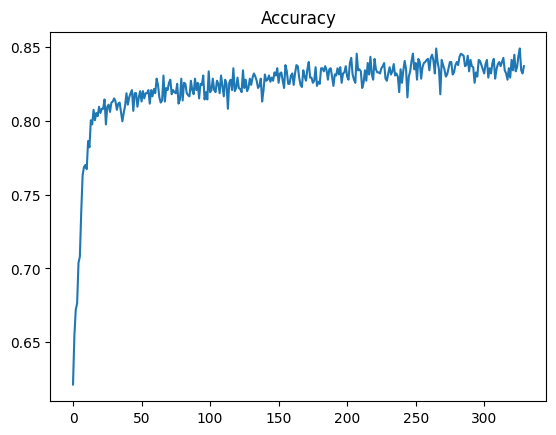

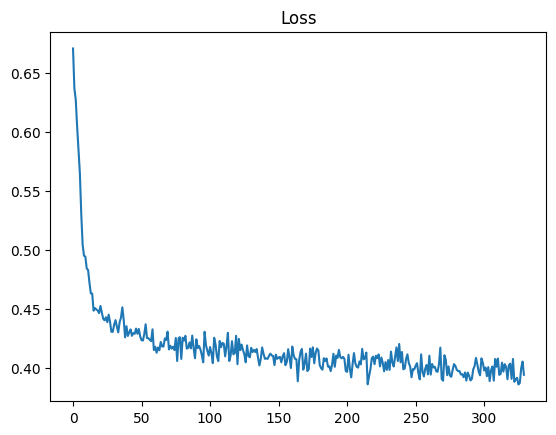

Epoch 1/1000
89/89 [==============================] - 1s 909us/step - loss: 0.6716 - accuracy: 0.6526
Epoch 2/1000
89/89 [==============================] - 0s 874us/step - loss: 0.6077 - accuracy: 0.6977
Epoch 3/1000
89/89 [==============================] - 0s 865us/step - loss: 0.5832 - accuracy: 0.7216
Epoch 4/1000
89/89 [==============================] - 0s 652us/step - loss: 0.5721 - accuracy: 0.7195
Epoch 5/1000
89/89 [==============================] - 0s 858us/step - loss: 0.5423 - accuracy: 0.7442
Epoch 6/1000
89/89 [==============================] - 0s 660us/step - loss: 0.5423 - accuracy: 0.7400
Epoch 7/1000
89/89 [==============================] - 0s 850us/step - loss: 0.5090 - accuracy: 0.7491
Epoch 8/1000
89/89 [==============================] - 0s 868us/step - loss: 0.4932 - accuracy: 0.7660
Epoch 9/1000
89/89 [==============================] - 0s 862us/step - loss: 0.4988 - accuracy: 0.7710
Epoch 10/1000
89/89 [==============================] - 0s 666us/step - loss: 0.492

89/89 [==============================] - 0s 1ms/step - loss: 0.4304 - accuracy: 0.8280
Epoch 81/1000
89/89 [==============================] - 0s 658us/step - loss: 0.4356 - accuracy: 0.8252
Epoch 82/1000
89/89 [==============================] - 0s 643us/step - loss: 0.4149 - accuracy: 0.8266
Epoch 83/1000
89/89 [==============================] - 0s 649us/step - loss: 0.4260 - accuracy: 0.8189
Epoch 84/1000
89/89 [==============================] - 0s 663us/step - loss: 0.4256 - accuracy: 0.8245
Epoch 85/1000
89/89 [==============================] - 0s 660us/step - loss: 0.4267 - accuracy: 0.8161
Epoch 86/1000
89/89 [==============================] - 0s 977us/step - loss: 0.4220 - accuracy: 0.8288
Epoch 87/1000
89/89 [==============================] - 0s 658us/step - loss: 0.4244 - accuracy: 0.8217
Epoch 88/1000
89/89 [==============================] - 0s 649us/step - loss: 0.4295 - accuracy: 0.8252
Epoch 89/1000
89/89 [==============================] - 0s 651us/step - loss: 0.4193 - acc

89/89 [==============================] - 0s 675us/step - loss: 0.4051 - accuracy: 0.8288
Epoch 160/1000
89/89 [==============================] - 0s 649us/step - loss: 0.4215 - accuracy: 0.8224
Epoch 161/1000
89/89 [==============================] - 0s 646us/step - loss: 0.4126 - accuracy: 0.8309
Epoch 162/1000
89/89 [==============================] - 0s 671us/step - loss: 0.4164 - accuracy: 0.8154
Epoch 163/1000
89/89 [==============================] - 0s 664us/step - loss: 0.4109 - accuracy: 0.8266
Epoch 164/1000
89/89 [==============================] - 0s 653us/step - loss: 0.4133 - accuracy: 0.8309
Epoch 165/1000
89/89 [==============================] - 0s 648us/step - loss: 0.4178 - accuracy: 0.8302
6/6 - 0s - loss: 0.3890 - accuracy: 0.8305 - 67ms/epoch - 11ms/step
6/6 - 0s - loss: 0.3773 - accuracy: 0.8427 - 15ms/epoch - 3ms/step


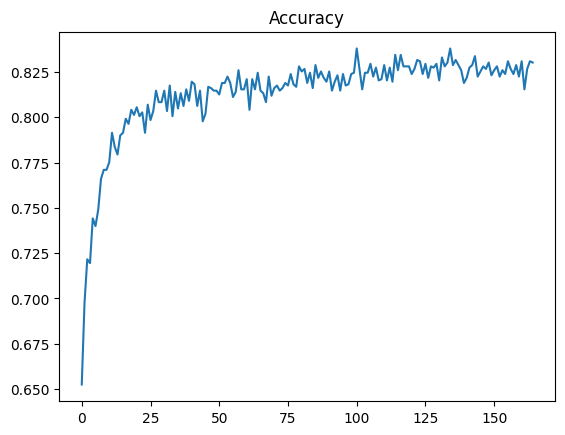

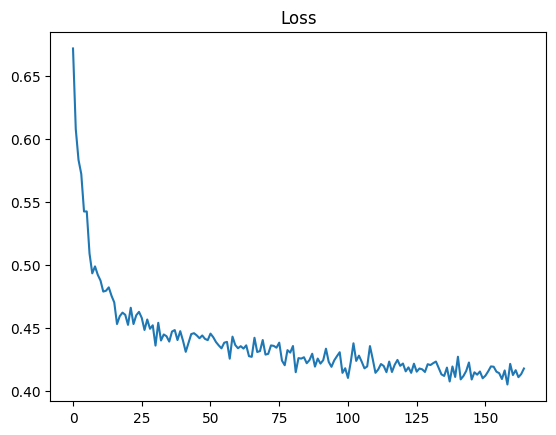

Epoch 1/1000
89/89 [==============================] - 1s 878us/step - loss: 0.6249 - accuracy: 0.6272
Epoch 2/1000
89/89 [==============================] - 0s 872us/step - loss: 0.5737 - accuracy: 0.6970
Epoch 3/1000
89/89 [==============================] - 0s 862us/step - loss: 0.5520 - accuracy: 0.7301
Epoch 4/1000
89/89 [==============================] - 0s 887us/step - loss: 0.5251 - accuracy: 0.7414
Epoch 5/1000
89/89 [==============================] - 0s 1ms/step - loss: 0.5070 - accuracy: 0.7653
Epoch 6/1000
89/89 [==============================] - 0s 896us/step - loss: 0.4874 - accuracy: 0.7717
Epoch 7/1000
89/89 [==============================] - 0s 875us/step - loss: 0.4669 - accuracy: 0.7822
Epoch 8/1000
89/89 [==============================] - 0s 869us/step - loss: 0.4745 - accuracy: 0.7844
Epoch 9/1000
89/89 [==============================] - 0s 865us/step - loss: 0.4747 - accuracy: 0.7851
Epoch 10/1000
89/89 [==============================] - 0s 675us/step - loss: 0.4676 

89/89 [==============================] - 0s 1ms/step - loss: 0.4099 - accuracy: 0.8323
Epoch 81/1000
89/89 [==============================] - 0s 669us/step - loss: 0.4125 - accuracy: 0.8224
Epoch 82/1000
89/89 [==============================] - 0s 659us/step - loss: 0.4155 - accuracy: 0.8273
Epoch 83/1000
89/89 [==============================] - 0s 648us/step - loss: 0.4150 - accuracy: 0.8316
Epoch 84/1000
89/89 [==============================] - 0s 675us/step - loss: 0.4145 - accuracy: 0.8238
Epoch 85/1000
89/89 [==============================] - 0s 677us/step - loss: 0.4181 - accuracy: 0.8217
Epoch 86/1000
89/89 [==============================] - 0s 676us/step - loss: 0.4208 - accuracy: 0.8280
Epoch 87/1000
89/89 [==============================] - 0s 682us/step - loss: 0.4189 - accuracy: 0.8295
Epoch 88/1000
89/89 [==============================] - 0s 664us/step - loss: 0.4186 - accuracy: 0.8189
Epoch 89/1000
89/89 [==============================] - 0s 983us/step - loss: 0.4019 - acc

89/89 [==============================] - 0s 666us/step - loss: 0.3942 - accuracy: 0.8379
Epoch 160/1000
89/89 [==============================] - 0s 675us/step - loss: 0.4107 - accuracy: 0.8302
Epoch 161/1000
89/89 [==============================] - 0s 653us/step - loss: 0.4108 - accuracy: 0.8302
Epoch 162/1000
89/89 [==============================] - 0s 666us/step - loss: 0.4048 - accuracy: 0.8344
Epoch 163/1000
89/89 [==============================] - 0s 675us/step - loss: 0.4033 - accuracy: 0.8400
Epoch 164/1000
89/89 [==============================] - 0s 665us/step - loss: 0.3917 - accuracy: 0.8421
Epoch 165/1000
89/89 [==============================] - 0s 665us/step - loss: 0.4146 - accuracy: 0.8245
Epoch 166/1000
89/89 [==============================] - 0s 660us/step - loss: 0.4037 - accuracy: 0.8344
Epoch 167/1000
89/89 [==============================] - 0s 664us/step - loss: 0.3994 - accuracy: 0.8407
Epoch 168/1000
89/89 [==============================] - 0s 653us/step - loss: 0

89/89 [==============================] - 0s 682us/step - loss: 0.3991 - accuracy: 0.8379
Epoch 238/1000
89/89 [==============================] - 0s 711us/step - loss: 0.4069 - accuracy: 0.8421
Epoch 239/1000
89/89 [==============================] - 0s 693us/step - loss: 0.3923 - accuracy: 0.8372
Epoch 240/1000
89/89 [==============================] - 0s 663us/step - loss: 0.3996 - accuracy: 0.8428
6/6 - 0s - loss: 0.4249 - accuracy: 0.8249 - 68ms/epoch - 11ms/step
6/6 - 0s - loss: 0.3628 - accuracy: 0.8539 - 14ms/epoch - 2ms/step


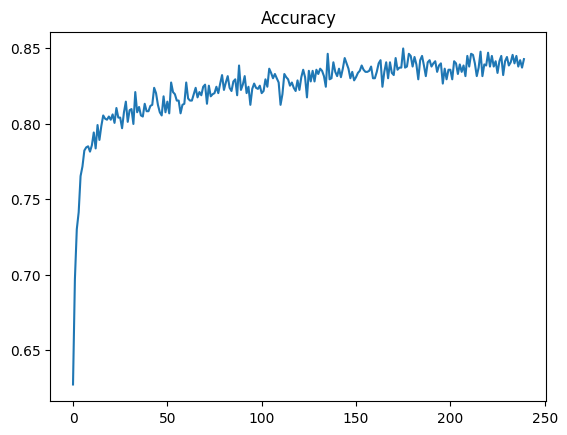

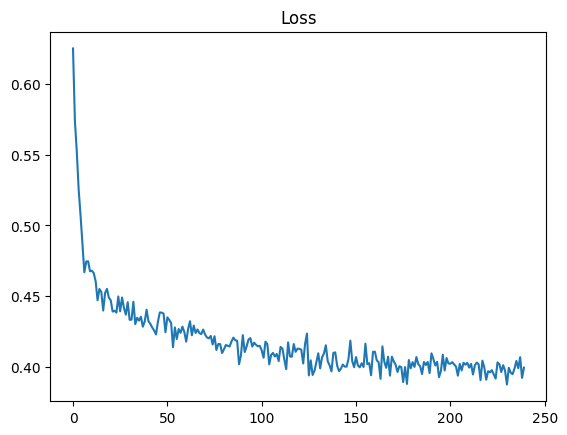

Epoch 1/1000
89/89 [==============================] - 1s 904us/step - loss: 0.6483 - accuracy: 0.6469
Epoch 2/1000
89/89 [==============================] - 0s 1ms/step - loss: 0.6133 - accuracy: 0.6610
Epoch 3/1000
89/89 [==============================] - 0s 1ms/step - loss: 0.5829 - accuracy: 0.6899
Epoch 4/1000
89/89 [==============================] - 0s 920us/step - loss: 0.5585 - accuracy: 0.7125
Epoch 5/1000
89/89 [==============================] - 0s 876us/step - loss: 0.5389 - accuracy: 0.7329
Epoch 6/1000
89/89 [==============================] - 0s 867us/step - loss: 0.5118 - accuracy: 0.7498
Epoch 7/1000
89/89 [==============================] - 0s 660us/step - loss: 0.5126 - accuracy: 0.7435
Epoch 8/1000
89/89 [==============================] - 0s 853us/step - loss: 0.4990 - accuracy: 0.7541
Epoch 9/1000
89/89 [==============================] - 0s 858us/step - loss: 0.4827 - accuracy: 0.7639
Epoch 10/1000
89/89 [==============================] - 0s 869us/step - loss: 0.4908 - 

89/89 [==============================] - 0s 677us/step - loss: 0.4147 - accuracy: 0.8154
Epoch 81/1000
89/89 [==============================] - 0s 889us/step - loss: 0.4181 - accuracy: 0.8245
Epoch 82/1000
89/89 [==============================] - 0s 675us/step - loss: 0.4103 - accuracy: 0.8203
Epoch 83/1000
89/89 [==============================] - 0s 653us/step - loss: 0.4291 - accuracy: 0.8196
Epoch 84/1000
89/89 [==============================] - 0s 644us/step - loss: 0.4231 - accuracy: 0.8210
Epoch 85/1000
89/89 [==============================] - 0s 662us/step - loss: 0.4223 - accuracy: 0.8210
Epoch 86/1000
89/89 [==============================] - 0s 661us/step - loss: 0.4154 - accuracy: 0.8203
Epoch 87/1000
89/89 [==============================] - 0s 675us/step - loss: 0.4281 - accuracy: 0.8118
Epoch 88/1000
89/89 [==============================] - 0s 703us/step - loss: 0.4221 - accuracy: 0.8182
Epoch 89/1000
89/89 [==============================] - 0s 1ms/step - loss: 0.4204 - acc

89/89 [==============================] - 0s 654us/step - loss: 0.4123 - accuracy: 0.8358
Epoch 160/1000
89/89 [==============================] - 0s 642us/step - loss: 0.4126 - accuracy: 0.8245
Epoch 161/1000
89/89 [==============================] - 0s 649us/step - loss: 0.4242 - accuracy: 0.8154
Epoch 162/1000
89/89 [==============================] - 0s 658us/step - loss: 0.4171 - accuracy: 0.8217
Epoch 163/1000
89/89 [==============================] - 0s 658us/step - loss: 0.4131 - accuracy: 0.8344
Epoch 164/1000
89/89 [==============================] - 0s 666us/step - loss: 0.4124 - accuracy: 0.8161
Epoch 165/1000
89/89 [==============================] - 0s 650us/step - loss: 0.4121 - accuracy: 0.8203
Epoch 166/1000
89/89 [==============================] - 0s 673us/step - loss: 0.4119 - accuracy: 0.8259
Epoch 167/1000
89/89 [==============================] - 0s 665us/step - loss: 0.4204 - accuracy: 0.8266
Epoch 168/1000
89/89 [==============================] - 0s 723us/step - loss: 0

Epoch 238/1000
89/89 [==============================] - 0s 663us/step - loss: 0.3985 - accuracy: 0.8302
Epoch 239/1000
89/89 [==============================] - 0s 653us/step - loss: 0.3974 - accuracy: 0.8330
Epoch 240/1000
89/89 [==============================] - 0s 659us/step - loss: 0.4061 - accuracy: 0.8386
Epoch 241/1000
89/89 [==============================] - 0s 658us/step - loss: 0.4064 - accuracy: 0.8358
Epoch 242/1000
89/89 [==============================] - 0s 659us/step - loss: 0.4020 - accuracy: 0.8365
Epoch 243/1000
89/89 [==============================] - 0s 666us/step - loss: 0.4068 - accuracy: 0.8379
Epoch 244/1000
89/89 [==============================] - 0s 692us/step - loss: 0.4066 - accuracy: 0.8351
Epoch 245/1000
89/89 [==============================] - 0s 682us/step - loss: 0.4017 - accuracy: 0.8337
Epoch 246/1000
89/89 [==============================] - 0s 665us/step - loss: 0.4165 - accuracy: 0.8259
Epoch 247/1000
89/89 [==============================] - 0s 682us

89/89 [==============================] - 0s 689us/step - loss: 0.3905 - accuracy: 0.8407
Epoch 317/1000
89/89 [==============================] - 0s 669us/step - loss: 0.3918 - accuracy: 0.8365
Epoch 318/1000
89/89 [==============================] - 0s 672us/step - loss: 0.3971 - accuracy: 0.8393
Epoch 319/1000
89/89 [==============================] - 0s 659us/step - loss: 0.3980 - accuracy: 0.8457
Epoch 320/1000
89/89 [==============================] - 0s 669us/step - loss: 0.4079 - accuracy: 0.8288
Epoch 321/1000
89/89 [==============================] - 0s 678us/step - loss: 0.3876 - accuracy: 0.8450
Epoch 322/1000
89/89 [==============================] - 0s 680us/step - loss: 0.4034 - accuracy: 0.8407
Epoch 323/1000
89/89 [==============================] - 0s 672us/step - loss: 0.3904 - accuracy: 0.8436
Epoch 324/1000
89/89 [==============================] - 0s 670us/step - loss: 0.4087 - accuracy: 0.8259
Epoch 325/1000
89/89 [==============================] - 0s 658us/step - loss: 0

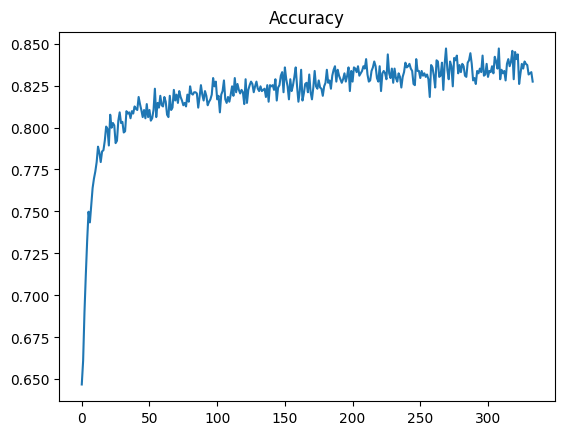

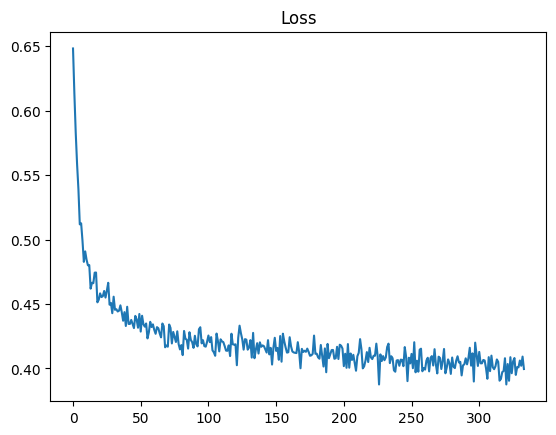

Epoch 1/1000
89/89 [==============================] - 1s 1ms/step - loss: 0.6611 - accuracy: 0.6152
Epoch 2/1000
89/89 [==============================] - 0s 888us/step - loss: 0.6203 - accuracy: 0.6850
Epoch 3/1000
89/89 [==============================] - 0s 894us/step - loss: 0.5924 - accuracy: 0.7075
Epoch 4/1000
89/89 [==============================] - 0s 886us/step - loss: 0.5777 - accuracy: 0.7252
Epoch 5/1000
89/89 [==============================] - 0s 881us/step - loss: 0.5554 - accuracy: 0.7364
Epoch 6/1000
89/89 [==============================] - 0s 898us/step - loss: 0.5423 - accuracy: 0.7463
Epoch 7/1000
89/89 [==============================] - 0s 884us/step - loss: 0.5223 - accuracy: 0.7533
Epoch 8/1000
89/89 [==============================] - 0s 878us/step - loss: 0.5191 - accuracy: 0.7597
Epoch 9/1000
89/89 [==============================] - 0s 881us/step - loss: 0.5051 - accuracy: 0.7667
Epoch 10/1000
89/89 [==============================] - 0s 898us/step - loss: 0.4933 

89/89 [==============================] - 0s 687us/step - loss: 0.4224 - accuracy: 0.8252
Epoch 81/1000
89/89 [==============================] - 0s 694us/step - loss: 0.4250 - accuracy: 0.8210
Epoch 82/1000
89/89 [==============================] - 0s 686us/step - loss: 0.4298 - accuracy: 0.8161
Epoch 83/1000
89/89 [==============================] - 0s 682us/step - loss: 0.4261 - accuracy: 0.8182
Epoch 84/1000
89/89 [==============================] - 0s 677us/step - loss: 0.4316 - accuracy: 0.8175
Epoch 85/1000
89/89 [==============================] - 0s 813us/step - loss: 0.4204 - accuracy: 0.8259
Epoch 86/1000
89/89 [==============================] - 0s 703us/step - loss: 0.4294 - accuracy: 0.8231
Epoch 87/1000
89/89 [==============================] - 0s 698us/step - loss: 0.4311 - accuracy: 0.8259
Epoch 88/1000
89/89 [==============================] - 0s 682us/step - loss: 0.4257 - accuracy: 0.8196
Epoch 89/1000
89/89 [==============================] - 0s 677us/step - loss: 0.4242 - a

89/89 [==============================] - 0s 682us/step - loss: 0.4125 - accuracy: 0.8266
Epoch 160/1000
89/89 [==============================] - 0s 682us/step - loss: 0.4166 - accuracy: 0.8295
Epoch 161/1000
89/89 [==============================] - 0s 688us/step - loss: 0.4080 - accuracy: 0.8344
Epoch 162/1000
89/89 [==============================] - 0s 693us/step - loss: 0.4189 - accuracy: 0.8330
Epoch 163/1000
89/89 [==============================] - 0s 704us/step - loss: 0.4096 - accuracy: 0.8316
Epoch 164/1000
89/89 [==============================] - 0s 711us/step - loss: 0.4166 - accuracy: 0.8266
Epoch 165/1000
89/89 [==============================] - 0s 699us/step - loss: 0.4050 - accuracy: 0.8316
Epoch 166/1000
89/89 [==============================] - 0s 705us/step - loss: 0.4058 - accuracy: 0.8330
Epoch 167/1000
89/89 [==============================] - 0s 780us/step - loss: 0.4063 - accuracy: 0.8344
Epoch 168/1000
89/89 [==============================] - 0s 778us/step - loss: 0

Epoch 238/1000
89/89 [==============================] - 0s 683us/step - loss: 0.4100 - accuracy: 0.8330
Epoch 239/1000
89/89 [==============================] - 0s 682us/step - loss: 0.4051 - accuracy: 0.8302
Epoch 240/1000
89/89 [==============================] - 0s 988us/step - loss: 0.3993 - accuracy: 0.8457
Epoch 241/1000
89/89 [==============================] - 0s 694us/step - loss: 0.4075 - accuracy: 0.8266
Epoch 242/1000
89/89 [==============================] - 0s 688us/step - loss: 0.3945 - accuracy: 0.8295
Epoch 243/1000
89/89 [==============================] - 0s 683us/step - loss: 0.3956 - accuracy: 0.8358
Epoch 244/1000
89/89 [==============================] - 0s 680us/step - loss: 0.4088 - accuracy: 0.8323
Epoch 245/1000
89/89 [==============================] - 0s 672us/step - loss: 0.3967 - accuracy: 0.8344
Epoch 246/1000
89/89 [==============================] - 0s 675us/step - loss: 0.3986 - accuracy: 0.8302
Epoch 247/1000
89/89 [==============================] - 0s 682us

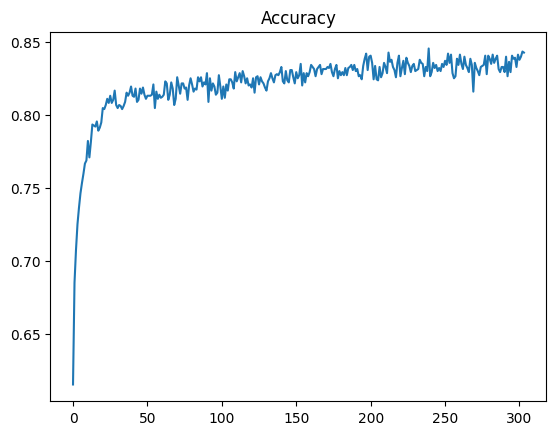

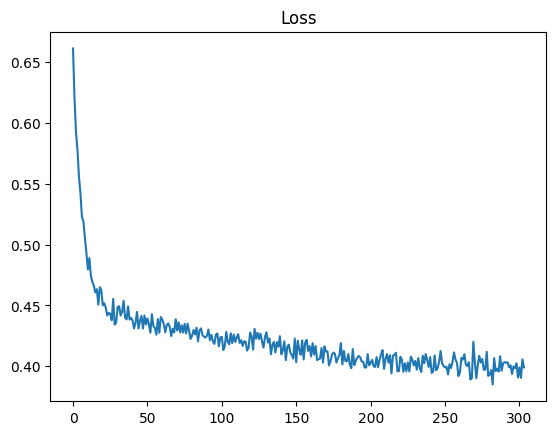

Epoch 1/1000
89/89 [==============================] - 1s 972us/step - loss: 0.6755 - accuracy: 0.6328
Epoch 2/1000
89/89 [==============================] - 0s 892us/step - loss: 0.6189 - accuracy: 0.6744
Epoch 3/1000
89/89 [==============================] - 0s 896us/step - loss: 0.5923 - accuracy: 0.6991
Epoch 4/1000
89/89 [==============================] - 0s 890us/step - loss: 0.5766 - accuracy: 0.7061
Epoch 5/1000
89/89 [==============================] - 0s 682us/step - loss: 0.5708 - accuracy: 0.6970
Epoch 6/1000
89/89 [==============================] - 0s 892us/step - loss: 0.5390 - accuracy: 0.7421
Epoch 7/1000
89/89 [==============================] - 0s 896us/step - loss: 0.5344 - accuracy: 0.7625
Epoch 8/1000
89/89 [==============================] - 0s 897us/step - loss: 0.5067 - accuracy: 0.7681
Epoch 9/1000
89/89 [==============================] - 0s 896us/step - loss: 0.4978 - accuracy: 0.7801
Epoch 10/1000
89/89 [==============================] - 0s 880us/step - loss: 0.497

89/89 [==============================] - 0s 956us/step - loss: 0.4312 - accuracy: 0.8309
Epoch 81/1000
89/89 [==============================] - 0s 839us/step - loss: 0.4308 - accuracy: 0.8210
Epoch 82/1000
89/89 [==============================] - 0s 768us/step - loss: 0.4429 - accuracy: 0.8161
Epoch 83/1000
89/89 [==============================] - 0s 749us/step - loss: 0.4396 - accuracy: 0.8168
Epoch 84/1000
89/89 [==============================] - 0s 715us/step - loss: 0.4422 - accuracy: 0.8196
Epoch 85/1000
89/89 [==============================] - 0s 712us/step - loss: 0.4385 - accuracy: 0.8090
Epoch 86/1000
89/89 [==============================] - 0s 710us/step - loss: 0.4301 - accuracy: 0.8238
Epoch 87/1000
89/89 [==============================] - 0s 709us/step - loss: 0.4297 - accuracy: 0.8238
Epoch 88/1000
89/89 [==============================] - 0s 716us/step - loss: 0.4344 - accuracy: 0.8175
Epoch 89/1000
89/89 [==============================] - 0s 716us/step - loss: 0.4298 - a

89/89 [==============================] - 0s 778us/step - loss: 0.4165 - accuracy: 0.8252
Epoch 160/1000
89/89 [==============================] - 0s 813us/step - loss: 0.4116 - accuracy: 0.8302
Epoch 161/1000
89/89 [==============================] - 0s 790us/step - loss: 0.4168 - accuracy: 0.8210
Epoch 162/1000
89/89 [==============================] - 0s 778us/step - loss: 0.4076 - accuracy: 0.8330
Epoch 163/1000
89/89 [==============================] - 0s 717us/step - loss: 0.4299 - accuracy: 0.8266
Epoch 164/1000
89/89 [==============================] - 0s 699us/step - loss: 0.4183 - accuracy: 0.8288
Epoch 165/1000
89/89 [==============================] - 0s 706us/step - loss: 0.4178 - accuracy: 0.8323
Epoch 166/1000
89/89 [==============================] - 0s 721us/step - loss: 0.4139 - accuracy: 0.8231
Epoch 167/1000
89/89 [==============================] - 0s 689us/step - loss: 0.4238 - accuracy: 0.8245
Epoch 168/1000
89/89 [==============================] - 0s 692us/step - loss: 0

Epoch 238/1000
89/89 [==============================] - 0s 705us/step - loss: 0.4200 - accuracy: 0.8316
Epoch 239/1000
89/89 [==============================] - 0s 727us/step - loss: 0.4196 - accuracy: 0.8231
Epoch 240/1000
89/89 [==============================] - 0s 722us/step - loss: 0.4137 - accuracy: 0.8323
Epoch 241/1000
89/89 [==============================] - 0s 733us/step - loss: 0.4059 - accuracy: 0.8295
Epoch 242/1000
89/89 [==============================] - 0s 721us/step - loss: 0.4127 - accuracy: 0.8351
Epoch 243/1000
89/89 [==============================] - 0s 751us/step - loss: 0.4128 - accuracy: 0.8330
Epoch 244/1000
89/89 [==============================] - 0s 715us/step - loss: 0.4144 - accuracy: 0.8393
Epoch 245/1000
89/89 [==============================] - 0s 721us/step - loss: 0.4142 - accuracy: 0.8238
Epoch 246/1000
89/89 [==============================] - 0s 722us/step - loss: 0.4071 - accuracy: 0.8323
Epoch 247/1000
89/89 [==============================] - 0s 722us

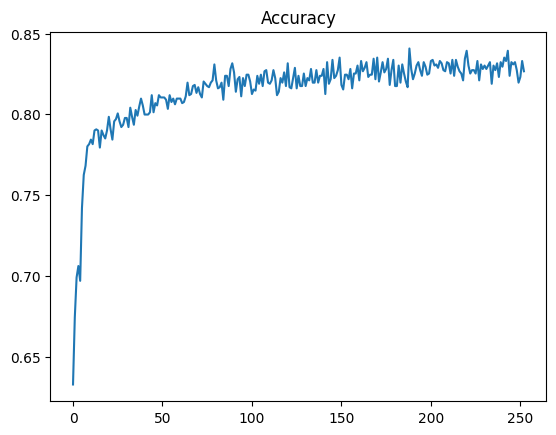

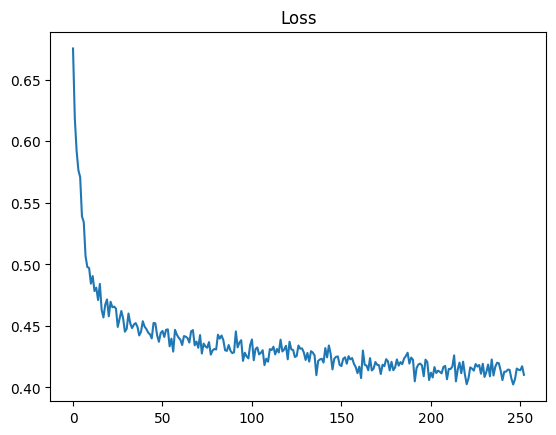

Epoch 1/1000
89/89 [==============================] - 1s 1ms/step - loss: 0.6714 - accuracy: 0.6110
Epoch 2/1000
89/89 [==============================] - 0s 973us/step - loss: 0.6298 - accuracy: 0.6646
Epoch 3/1000
89/89 [==============================] - 0s 954us/step - loss: 0.5965 - accuracy: 0.7104
Epoch 4/1000
89/89 [==============================] - 0s 847us/step - loss: 0.5802 - accuracy: 0.7061
Epoch 5/1000
89/89 [==============================] - 0s 972us/step - loss: 0.5475 - accuracy: 0.7484
Epoch 6/1000
89/89 [==============================] - 0s 921us/step - loss: 0.5326 - accuracy: 0.7526
Epoch 7/1000
89/89 [==============================] - 0s 950us/step - loss: 0.5092 - accuracy: 0.7674
Epoch 8/1000
89/89 [==============================] - 0s 949us/step - loss: 0.4923 - accuracy: 0.7681
Epoch 9/1000
89/89 [==============================] - 0s 962us/step - loss: 0.4880 - accuracy: 0.7794
Epoch 10/1000
89/89 [==============================] - 0s 940us/step - loss: 0.4809 

89/89 [==============================] - 0s 710us/step - loss: 0.4356 - accuracy: 0.8111
Epoch 81/1000
89/89 [==============================] - 0s 732us/step - loss: 0.4336 - accuracy: 0.8189
Epoch 82/1000
89/89 [==============================] - 0s 722us/step - loss: 0.4237 - accuracy: 0.8238
Epoch 83/1000
89/89 [==============================] - 0s 721us/step - loss: 0.4323 - accuracy: 0.8140
Epoch 84/1000
89/89 [==============================] - 0s 755us/step - loss: 0.4427 - accuracy: 0.8231
Epoch 85/1000
89/89 [==============================] - 0s 745us/step - loss: 0.4293 - accuracy: 0.8224
Epoch 86/1000
89/89 [==============================] - 0s 710us/step - loss: 0.4364 - accuracy: 0.8238
Epoch 87/1000
89/89 [==============================] - 0s 716us/step - loss: 0.4266 - accuracy: 0.8210
Epoch 88/1000
89/89 [==============================] - 0s 722us/step - loss: 0.4375 - accuracy: 0.8217
Epoch 89/1000
89/89 [==============================] - 0s 790us/step - loss: 0.4277 - a

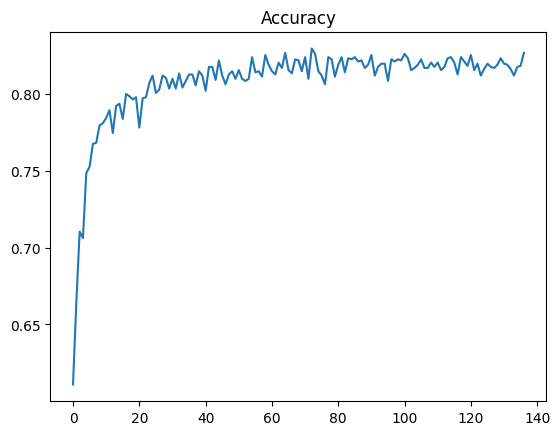

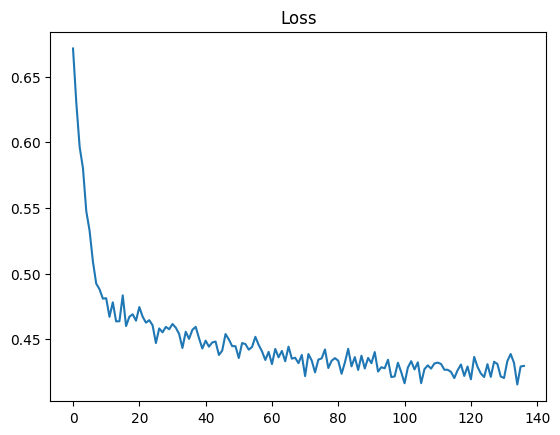

Average accuracy train:  0.8410867717530992
Average accuracy valid:  0.8245519333415561
Average accuracy test:  0.8395755092302958


In [23]:
from sklearn.model_selection import KFold

train_accuracy = []
valid_accuracy = []
test_accuracy = []

patience = 64
batch_size = 16
max_epochs = 1000
learning_rate = 0.001

checkpoint_filepath = "checkpoints/checkpoint_weights"

history = []

for train_index,valid_index in KFold(9).split(X):
    
    X_train,X_valid=X.iloc[train_index],X.iloc[valid_index]
    y_train,y_valid=y.iloc[train_index],y.iloc[valid_index]
  
    model = create_model(learning_rate)
    history = model.fit(X_train, y_train, epochs=max_epochs, batch_size = batch_size, callbacks=get_callbacks(patience, checkpoint_filepath))

    train_accuracy.append(history.history['accuracy'][len(history.history['accuracy']) - patience - 1])

    model.load_weights(checkpoint_filepath)

    valid_loss, valid_acc = model.evaluate(X_valid,  y_valid, verbose=2)

    valid_accuracy.append(valid_acc)

    test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

    test_accuracy.append(test_acc)
    
    plt.plot(history.history['accuracy'])
    plt.title(label="Accuracy")
    plt.show()
    plt.plot(history.history['loss'])
    plt.title(label="Loss")
    plt.show()
    

print("Average accuracy train: ", np.mean(train_accuracy))
print("Average accuracy valid: ", np.mean(valid_accuracy))
print("Average accuracy test: ", np.mean(test_accuracy))
  

### PyTorch implementation (same structure and hyperparameters as tensorflow)

In [29]:
from torch.nn import Linear
from torch.nn import LeakyReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.nn import Dropout
from torch.optim import NAdam
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import accuracy_score
from numpy import vstack

### Model implementation

In [47]:
class MLP(Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        
        self.hidden1 = Linear(n_inputs, 8)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='leaky_relu')
        self.act1 = LeakyReLU()
        
        self.dropout1 = Dropout(0.15)

        self.hidden2 = Linear(8, 16)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='leaky_relu')
        self.act2 = LeakyReLU()
        
        self.dropout2 = Dropout(0.15)

        self.hidden3 = Linear(16, 8)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='leaky_relu')
        self.act3 = LeakyReLU()
        
        self.dropout3 = Dropout(0.15)

        self.hidden4 = Linear(8, 1)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = Sigmoid()
 
    def forward(self, X):

        X = self.hidden1(X)
        X = self.act1(X)
        
        X = self.dropout1(X)

        X = self.hidden2(X)
        X = self.act2(X)
        
        X = self.dropout2(X)

        X = self.hidden3(X)
        X = self.act3(X)
        
        X = self.dropout3(X)
        
        X = self.hidden4(X)
        X = self.act4(X)
        
        return X

### Model training implementation (epochs, early stopping, checkpoint)

In [57]:
def model_train(model, train_data, max_epochs, patience, filepath):
    criterion = BCELoss()
    optimizer = NAdam(model.parameters(), lr=0.001)
    current_acc = 0
    epochs_no_improvement = 0
    acc_list = []
    for epoch in range(max_epochs):
        for X, y in train_data:
            optimizer.zero_grad()
            yhat = model(X)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            
        acc = evaluate_model(model, train_data)
        acc_list.append(acc)
        print("Current epoch: " + str(epoch) + " Accuracy: " + str(acc))
        if acc > current_acc:
            current_acc = acc
            epochs_no_improvement = 0
            torch.save(model, filepath)
            
        else:
            epochs_no_improvement += 1
        
        if epochs_no_improvement >= patience or epoch == max_epochs - 1:
            new_model = torch.load(filepath)
            plt.plot(acc_list)
            plt.title(label="Accuracy")
            plt.show()
            return current_acc, new_model

### Accuracy evaluation of model

In [58]:
def evaluate_model(model, test_data):
    predictions, actuals = list(), list()
    for X, y in test_data:
        yhat = model(X)
        yhat = yhat.detach().numpy()
        actual = y.numpy()
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.round()
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    acc = accuracy_score(actuals, predictions)
    return acc

### Model cross validation

(177, 7)
(1418, 7)
(178, 7)
Current epoch: 0 Accuracy: 0.5730337078651685
Current epoch: 1 Accuracy: 0.5617977528089888
Current epoch: 2 Accuracy: 0.5842696629213483
Current epoch: 3 Accuracy: 0.5786516853932584
Current epoch: 4 Accuracy: 0.550561797752809
Current epoch: 5 Accuracy: 0.5898876404494382
Current epoch: 6 Accuracy: 0.5337078651685393
Current epoch: 7 Accuracy: 0.5449438202247191
Current epoch: 8 Accuracy: 0.5337078651685393
Current epoch: 9 Accuracy: 0.5955056179775281
Current epoch: 10 Accuracy: 0.5730337078651685
Current epoch: 11 Accuracy: 0.5561797752808989
Current epoch: 12 Accuracy: 0.5674157303370787
Current epoch: 13 Accuracy: 0.5786516853932584
Current epoch: 14 Accuracy: 0.5617977528089888
Current epoch: 15 Accuracy: 0.5674157303370787
Current epoch: 16 Accuracy: 0.5898876404494382
Current epoch: 17 Accuracy: 0.5674157303370787
Current epoch: 18 Accuracy: 0.5786516853932584
Current epoch: 19 Accuracy: 0.6067415730337079
Current epoch: 20 Accuracy: 0.6179775280898

Current epoch: 183 Accuracy: 0.8033707865168539
Current epoch: 184 Accuracy: 0.7752808988764045
Current epoch: 185 Accuracy: 0.7584269662921348
Current epoch: 186 Accuracy: 0.7303370786516854
Current epoch: 187 Accuracy: 0.7921348314606742
Current epoch: 188 Accuracy: 0.7752808988764045
Current epoch: 189 Accuracy: 0.7640449438202247
Current epoch: 190 Accuracy: 0.8033707865168539
Current epoch: 191 Accuracy: 0.8089887640449438
Current epoch: 192 Accuracy: 0.8033707865168539
Current epoch: 193 Accuracy: 0.7865168539325843
Current epoch: 194 Accuracy: 0.7584269662921348
Current epoch: 195 Accuracy: 0.8033707865168539
Current epoch: 196 Accuracy: 0.7808988764044944
Current epoch: 197 Accuracy: 0.7865168539325843
Current epoch: 198 Accuracy: 0.7752808988764045
Current epoch: 199 Accuracy: 0.8314606741573034
Current epoch: 200 Accuracy: 0.8258426966292135
Current epoch: 201 Accuracy: 0.7752808988764045
Current epoch: 202 Accuracy: 0.7584269662921348
Current epoch: 203 Accuracy: 0.769662921

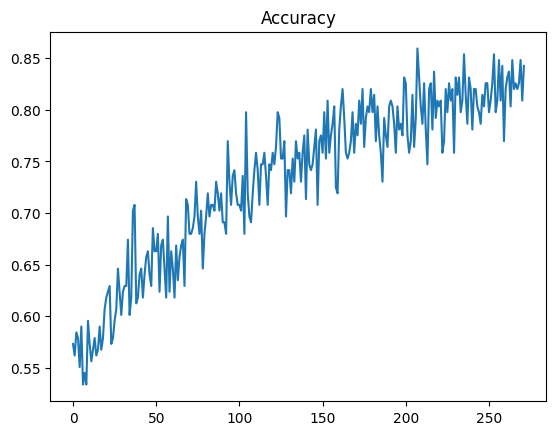

(1418, 7)
(178, 7)
Current epoch: 0 Accuracy: 0.5056179775280899
Current epoch: 1 Accuracy: 0.5898876404494382
Current epoch: 2 Accuracy: 0.5786516853932584
Current epoch: 3 Accuracy: 0.5674157303370787
Current epoch: 4 Accuracy: 0.601123595505618
Current epoch: 5 Accuracy: 0.6179775280898876
Current epoch: 6 Accuracy: 0.6067415730337079
Current epoch: 7 Accuracy: 0.651685393258427
Current epoch: 8 Accuracy: 0.5730337078651685
Current epoch: 9 Accuracy: 0.6797752808988764
Current epoch: 10 Accuracy: 0.651685393258427
Current epoch: 11 Accuracy: 0.6853932584269663
Current epoch: 12 Accuracy: 0.6404494382022472
Current epoch: 13 Accuracy: 0.6404494382022472
Current epoch: 14 Accuracy: 0.6685393258426966
Current epoch: 15 Accuracy: 0.6966292134831461
Current epoch: 16 Accuracy: 0.6741573033707865
Current epoch: 17 Accuracy: 0.6685393258426966
Current epoch: 18 Accuracy: 0.702247191011236
Current epoch: 19 Accuracy: 0.6797752808988764
Current epoch: 20 Accuracy: 0.6966292134831461
Current 

Current epoch: 177 Accuracy: 0.8426966292134831
Current epoch: 178 Accuracy: 0.8202247191011236
Current epoch: 179 Accuracy: 0.8595505617977528
Current epoch: 180 Accuracy: 0.8370786516853933
Current epoch: 181 Accuracy: 0.8258426966292135
Current epoch: 182 Accuracy: 0.8146067415730337
Current epoch: 183 Accuracy: 0.848314606741573
Current epoch: 184 Accuracy: 0.8426966292134831
Current epoch: 185 Accuracy: 0.8595505617977528
Current epoch: 186 Accuracy: 0.8426966292134831
Current epoch: 187 Accuracy: 0.8370786516853933
Current epoch: 188 Accuracy: 0.8651685393258427
Current epoch: 189 Accuracy: 0.8539325842696629
Current epoch: 190 Accuracy: 0.8651685393258427
Current epoch: 191 Accuracy: 0.8707865168539326
Current epoch: 192 Accuracy: 0.8202247191011236
Current epoch: 193 Accuracy: 0.8595505617977528
Current epoch: 194 Accuracy: 0.848314606741573
Current epoch: 195 Accuracy: 0.8258426966292135
Current epoch: 196 Accuracy: 0.8089887640449438
Current epoch: 197 Accuracy: 0.83707865168

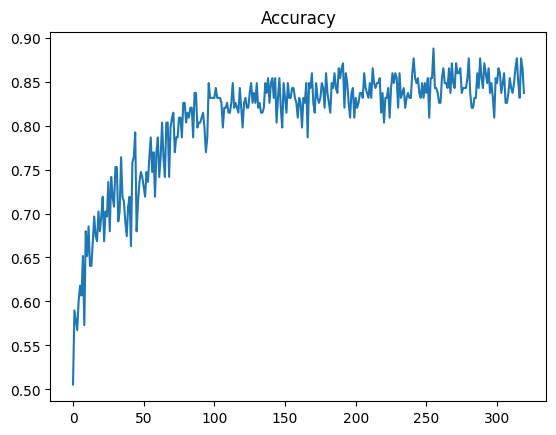

(1418, 7)
(178, 7)
Current epoch: 0 Accuracy: 0.7078651685393258
Current epoch: 1 Accuracy: 0.6797752808988764
Current epoch: 2 Accuracy: 0.7415730337078652
Current epoch: 3 Accuracy: 0.702247191011236
Current epoch: 4 Accuracy: 0.7191011235955056
Current epoch: 5 Accuracy: 0.7247191011235955
Current epoch: 6 Accuracy: 0.7303370786516854
Current epoch: 7 Accuracy: 0.7303370786516854
Current epoch: 8 Accuracy: 0.702247191011236
Current epoch: 9 Accuracy: 0.7303370786516854
Current epoch: 10 Accuracy: 0.7191011235955056
Current epoch: 11 Accuracy: 0.7471910112359551
Current epoch: 12 Accuracy: 0.7584269662921348
Current epoch: 13 Accuracy: 0.7584269662921348
Current epoch: 14 Accuracy: 0.7359550561797753
Current epoch: 15 Accuracy: 0.7415730337078652
Current epoch: 16 Accuracy: 0.7696629213483146
Current epoch: 17 Accuracy: 0.7640449438202247
Current epoch: 18 Accuracy: 0.7696629213483146
Current epoch: 19 Accuracy: 0.7415730337078652
Current epoch: 20 Accuracy: 0.7415730337078652
Curren

Current epoch: 182 Accuracy: 0.797752808988764
Current epoch: 183 Accuracy: 0.8146067415730337
Current epoch: 184 Accuracy: 0.8258426966292135
Current epoch: 185 Accuracy: 0.7921348314606742
Current epoch: 186 Accuracy: 0.8370786516853933
Current epoch: 187 Accuracy: 0.8033707865168539
Current epoch: 188 Accuracy: 0.8089887640449438
Current epoch: 189 Accuracy: 0.8370786516853933
Current epoch: 190 Accuracy: 0.8033707865168539
Current epoch: 191 Accuracy: 0.8314606741573034
Current epoch: 192 Accuracy: 0.797752808988764
Current epoch: 193 Accuracy: 0.8033707865168539
Current epoch: 194 Accuracy: 0.848314606741573
Current epoch: 195 Accuracy: 0.8146067415730337
Current epoch: 196 Accuracy: 0.848314606741573
Current epoch: 197 Accuracy: 0.797752808988764
Current epoch: 198 Accuracy: 0.8146067415730337
Current epoch: 199 Accuracy: 0.8146067415730337
Current epoch: 200 Accuracy: 0.8089887640449438
Current epoch: 201 Accuracy: 0.8146067415730337
Current epoch: 202 Accuracy: 0.82584269662921

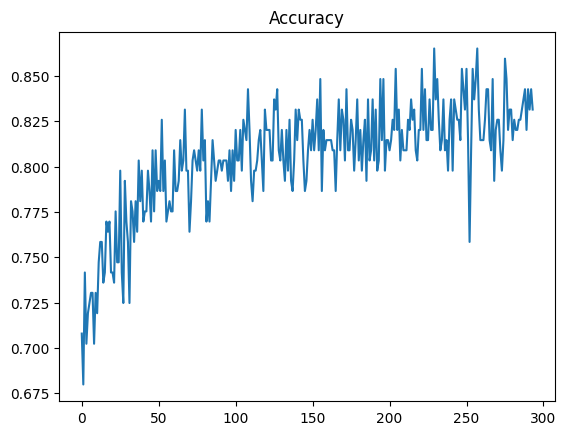

(1419, 7)
(177, 7)
Current epoch: 0 Accuracy: 0.5480225988700564
Current epoch: 1 Accuracy: 0.559322033898305
Current epoch: 2 Accuracy: 0.5706214689265536
Current epoch: 3 Accuracy: 0.5875706214689266
Current epoch: 4 Accuracy: 0.6214689265536724
Current epoch: 5 Accuracy: 0.6045197740112994
Current epoch: 6 Accuracy: 0.6214689265536724
Current epoch: 7 Accuracy: 0.6214689265536724
Current epoch: 8 Accuracy: 0.655367231638418
Current epoch: 9 Accuracy: 0.6271186440677966
Current epoch: 10 Accuracy: 0.6666666666666666
Current epoch: 11 Accuracy: 0.6610169491525424
Current epoch: 12 Accuracy: 0.6045197740112994
Current epoch: 13 Accuracy: 0.672316384180791
Current epoch: 14 Accuracy: 0.655367231638418
Current epoch: 15 Accuracy: 0.6666666666666666
Current epoch: 16 Accuracy: 0.6384180790960452
Current epoch: 17 Accuracy: 0.6610169491525424
Current epoch: 18 Accuracy: 0.5932203389830508
Current epoch: 19 Accuracy: 0.672316384180791
Current epoch: 20 Accuracy: 0.6610169491525424
Current e

Current epoch: 186 Accuracy: 0.807909604519774
Current epoch: 187 Accuracy: 0.8248587570621468
Current epoch: 188 Accuracy: 0.8135593220338984
Current epoch: 189 Accuracy: 0.7966101694915254
Current epoch: 190 Accuracy: 0.8022598870056498
Current epoch: 191 Accuracy: 0.8418079096045198
Current epoch: 192 Accuracy: 0.8305084745762712
Current epoch: 193 Accuracy: 0.8135593220338984
Current epoch: 194 Accuracy: 0.8192090395480226
Current epoch: 195 Accuracy: 0.847457627118644
Current epoch: 196 Accuracy: 0.8248587570621468


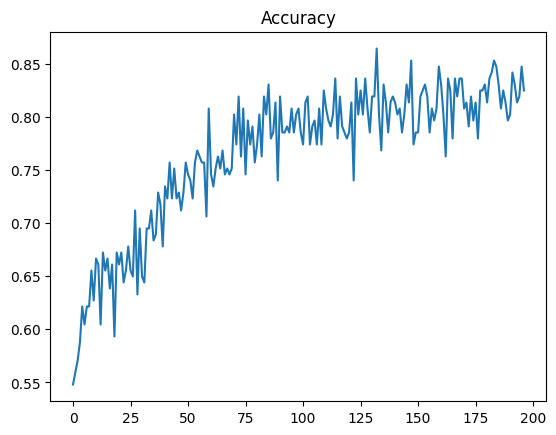

(1419, 7)
(177, 7)
Current epoch: 0 Accuracy: 0.519774011299435
Current epoch: 1 Accuracy: 0.4858757062146893
Current epoch: 2 Accuracy: 0.480225988700565
Current epoch: 3 Accuracy: 0.5536723163841808
Current epoch: 4 Accuracy: 0.5536723163841808
Current epoch: 5 Accuracy: 0.4745762711864407
Current epoch: 6 Accuracy: 0.5988700564971752
Current epoch: 7 Accuracy: 0.5141242937853108
Current epoch: 8 Accuracy: 0.6045197740112994
Current epoch: 9 Accuracy: 0.576271186440678
Current epoch: 10 Accuracy: 0.615819209039548
Current epoch: 11 Accuracy: 0.5819209039548022
Current epoch: 12 Accuracy: 0.6214689265536724
Current epoch: 13 Accuracy: 0.5988700564971752
Current epoch: 14 Accuracy: 0.615819209039548
Current epoch: 15 Accuracy: 0.5819209039548022
Current epoch: 16 Accuracy: 0.655367231638418
Current epoch: 17 Accuracy: 0.6101694915254238
Current epoch: 18 Accuracy: 0.672316384180791
Current epoch: 19 Accuracy: 0.655367231638418
Current epoch: 20 Accuracy: 0.6271186440677966
Current epoc

Current epoch: 184 Accuracy: 0.8248587570621468
Current epoch: 185 Accuracy: 0.7796610169491526
Current epoch: 186 Accuracy: 0.8192090395480226
Current epoch: 187 Accuracy: 0.8248587570621468
Current epoch: 188 Accuracy: 0.8248587570621468
Current epoch: 189 Accuracy: 0.7570621468926554
Current epoch: 190 Accuracy: 0.807909604519774
Current epoch: 191 Accuracy: 0.7966101694915254
Current epoch: 192 Accuracy: 0.7966101694915254
Current epoch: 193 Accuracy: 0.807909604519774
Current epoch: 194 Accuracy: 0.807909604519774
Current epoch: 195 Accuracy: 0.7966101694915254
Current epoch: 196 Accuracy: 0.8305084745762712
Current epoch: 197 Accuracy: 0.7909604519774012
Current epoch: 198 Accuracy: 0.807909604519774
Current epoch: 199 Accuracy: 0.8192090395480226
Current epoch: 200 Accuracy: 0.8305084745762712
Current epoch: 201 Accuracy: 0.7740112994350282
Current epoch: 202 Accuracy: 0.8248587570621468
Current epoch: 203 Accuracy: 0.7966101694915254
Current epoch: 204 Accuracy: 0.7853107344632

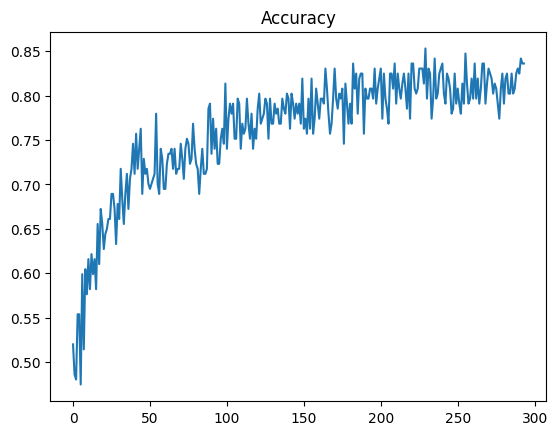

(1419, 7)
(177, 7)
Current epoch: 0 Accuracy: 0.519774011299435
Current epoch: 1 Accuracy: 0.4745762711864407
Current epoch: 2 Accuracy: 0.5141242937853108
Current epoch: 3 Accuracy: 0.5932203389830508
Current epoch: 4 Accuracy: 0.4745762711864407
Current epoch: 5 Accuracy: 0.5819209039548022
Current epoch: 6 Accuracy: 0.5254237288135594
Current epoch: 7 Accuracy: 0.5706214689265536
Current epoch: 8 Accuracy: 0.5875706214689266
Current epoch: 9 Accuracy: 0.5480225988700564
Current epoch: 10 Accuracy: 0.5423728813559322
Current epoch: 11 Accuracy: 0.5819209039548022
Current epoch: 12 Accuracy: 0.5084745762711864
Current epoch: 13 Accuracy: 0.5423728813559322
Current epoch: 14 Accuracy: 0.615819209039548
Current epoch: 15 Accuracy: 0.6045197740112994
Current epoch: 16 Accuracy: 0.536723163841808
Current epoch: 17 Accuracy: 0.576271186440678
Current epoch: 18 Accuracy: 0.6045197740112994
Current epoch: 19 Accuracy: 0.5988700564971752
Current epoch: 20 Accuracy: 0.6440677966101694
Current 

Current epoch: 178 Accuracy: 0.7853107344632768
Current epoch: 179 Accuracy: 0.8135593220338984
Current epoch: 180 Accuracy: 0.7966101694915254
Current epoch: 181 Accuracy: 0.7401129943502824
Current epoch: 182 Accuracy: 0.768361581920904
Current epoch: 183 Accuracy: 0.7853107344632768
Current epoch: 184 Accuracy: 0.8248587570621468
Current epoch: 185 Accuracy: 0.7740112994350282
Current epoch: 186 Accuracy: 0.7627118644067796
Current epoch: 187 Accuracy: 0.7909604519774012
Current epoch: 188 Accuracy: 0.8022598870056498
Current epoch: 189 Accuracy: 0.751412429378531
Current epoch: 190 Accuracy: 0.7796610169491526
Current epoch: 191 Accuracy: 0.751412429378531
Current epoch: 192 Accuracy: 0.7344632768361582
Current epoch: 193 Accuracy: 0.8135593220338984
Current epoch: 194 Accuracy: 0.807909604519774
Current epoch: 195 Accuracy: 0.7740112994350282
Current epoch: 196 Accuracy: 0.7740112994350282
Current epoch: 197 Accuracy: 0.7909604519774012
Current epoch: 198 Accuracy: 0.8022598870056

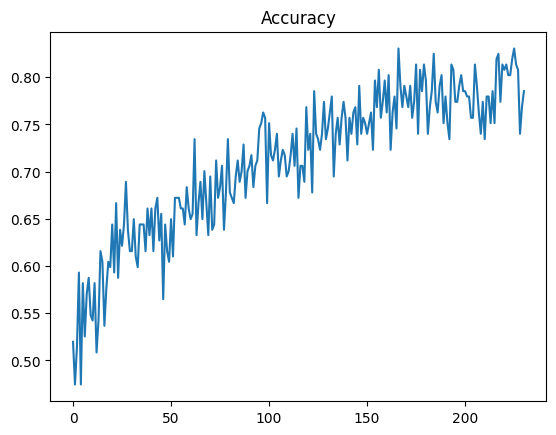

(1419, 7)
(177, 7)
Current epoch: 0 Accuracy: 0.4463276836158192
Current epoch: 1 Accuracy: 0.4406779661016949
Current epoch: 2 Accuracy: 0.3728813559322034
Current epoch: 3 Accuracy: 0.4915254237288136
Current epoch: 4 Accuracy: 0.4632768361581921
Current epoch: 5 Accuracy: 0.5254237288135594
Current epoch: 6 Accuracy: 0.5819209039548022
Current epoch: 7 Accuracy: 0.5536723163841808
Current epoch: 8 Accuracy: 0.6045197740112994
Current epoch: 9 Accuracy: 0.5649717514124294
Current epoch: 10 Accuracy: 0.632768361581921
Current epoch: 11 Accuracy: 0.5875706214689266
Current epoch: 12 Accuracy: 0.6497175141242938
Current epoch: 13 Accuracy: 0.632768361581921
Current epoch: 14 Accuracy: 0.6271186440677966
Current epoch: 15 Accuracy: 0.632768361581921
Current epoch: 16 Accuracy: 0.6384180790960452
Current epoch: 17 Accuracy: 0.6892655367231638
Current epoch: 18 Accuracy: 0.6779661016949152
Current epoch: 19 Accuracy: 0.6666666666666666
Current epoch: 20 Accuracy: 0.6892655367231638
Current

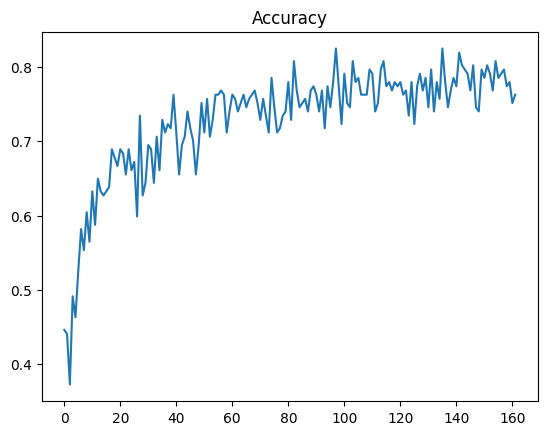

(1419, 7)
(177, 7)
Current epoch: 0 Accuracy: 0.4463276836158192
Current epoch: 1 Accuracy: 0.4632768361581921
Current epoch: 2 Accuracy: 0.5028248587570622
Current epoch: 3 Accuracy: 0.4971751412429379
Current epoch: 4 Accuracy: 0.519774011299435
Current epoch: 5 Accuracy: 0.5649717514124294
Current epoch: 6 Accuracy: 0.615819209039548
Current epoch: 7 Accuracy: 0.632768361581921
Current epoch: 8 Accuracy: 0.6384180790960452
Current epoch: 9 Accuracy: 0.5932203389830508
Current epoch: 10 Accuracy: 0.6101694915254238
Current epoch: 11 Accuracy: 0.6384180790960452
Current epoch: 12 Accuracy: 0.6045197740112994
Current epoch: 13 Accuracy: 0.5932203389830508
Current epoch: 14 Accuracy: 0.7062146892655368
Current epoch: 15 Accuracy: 0.6384180790960452
Current epoch: 16 Accuracy: 0.672316384180791
Current epoch: 17 Accuracy: 0.6779661016949152
Current epoch: 18 Accuracy: 0.711864406779661
Current epoch: 19 Accuracy: 0.6666666666666666
Current epoch: 20 Accuracy: 0.6779661016949152
Current e

Current epoch: 174 Accuracy: 0.847457627118644
Current epoch: 175 Accuracy: 0.8192090395480226
Current epoch: 176 Accuracy: 0.8192090395480226
Current epoch: 177 Accuracy: 0.8418079096045198
Current epoch: 178 Accuracy: 0.8361581920903954
Current epoch: 179 Accuracy: 0.8361581920903954
Current epoch: 180 Accuracy: 0.8361581920903954
Current epoch: 181 Accuracy: 0.8248587570621468
Current epoch: 182 Accuracy: 0.807909604519774
Current epoch: 183 Accuracy: 0.8192090395480226
Current epoch: 184 Accuracy: 0.8587570621468926
Current epoch: 185 Accuracy: 0.8305084745762712
Current epoch: 186 Accuracy: 0.8135593220338984
Current epoch: 187 Accuracy: 0.807909604519774
Current epoch: 188 Accuracy: 0.8022598870056498
Current epoch: 189 Accuracy: 0.8135593220338984
Current epoch: 190 Accuracy: 0.807909604519774
Current epoch: 191 Accuracy: 0.8248587570621468
Current epoch: 192 Accuracy: 0.847457627118644
Current epoch: 193 Accuracy: 0.8248587570621468
Current epoch: 194 Accuracy: 0.79096045197740

Current epoch: 350 Accuracy: 0.847457627118644
Current epoch: 351 Accuracy: 0.8587570621468926
Current epoch: 352 Accuracy: 0.864406779661017
Current epoch: 353 Accuracy: 0.8587570621468926
Current epoch: 354 Accuracy: 0.864406779661017
Current epoch: 355 Accuracy: 0.8870056497175142
Current epoch: 356 Accuracy: 0.903954802259887
Current epoch: 357 Accuracy: 0.8757062146892656
Current epoch: 358 Accuracy: 0.8531073446327684
Current epoch: 359 Accuracy: 0.8813559322033898
Current epoch: 360 Accuracy: 0.8587570621468926
Current epoch: 361 Accuracy: 0.8870056497175142
Current epoch: 362 Accuracy: 0.8587570621468926
Current epoch: 363 Accuracy: 0.8587570621468926


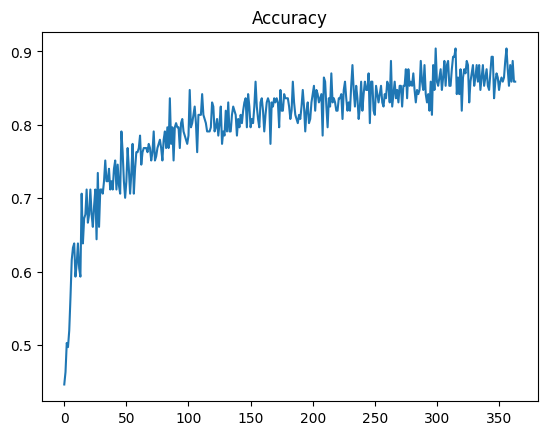

(1419, 7)
(177, 7)
Current epoch: 0 Accuracy: 0.4576271186440678
Current epoch: 1 Accuracy: 0.4745762711864407
Current epoch: 2 Accuracy: 0.4915254237288136
Current epoch: 3 Accuracy: 0.5254237288135594
Current epoch: 4 Accuracy: 0.4858757062146893
Current epoch: 5 Accuracy: 0.559322033898305
Current epoch: 6 Accuracy: 0.5028248587570622
Current epoch: 7 Accuracy: 0.480225988700565
Current epoch: 8 Accuracy: 0.5254237288135594
Current epoch: 9 Accuracy: 0.519774011299435
Current epoch: 10 Accuracy: 0.536723163841808
Current epoch: 11 Accuracy: 0.6101694915254238
Current epoch: 12 Accuracy: 0.5706214689265536
Current epoch: 13 Accuracy: 0.5480225988700564
Current epoch: 14 Accuracy: 0.6045197740112994
Current epoch: 15 Accuracy: 0.6214689265536724
Current epoch: 16 Accuracy: 0.5649717514124294
Current epoch: 17 Accuracy: 0.576271186440678
Current epoch: 18 Accuracy: 0.6214689265536724
Current epoch: 19 Accuracy: 0.615819209039548
Current epoch: 20 Accuracy: 0.655367231638418
Current epo

Current epoch: 174 Accuracy: 0.7909604519774012
Current epoch: 175 Accuracy: 0.7909604519774012
Current epoch: 176 Accuracy: 0.8022598870056498
Current epoch: 177 Accuracy: 0.7853107344632768
Current epoch: 178 Accuracy: 0.768361581920904
Current epoch: 179 Accuracy: 0.8022598870056498
Current epoch: 180 Accuracy: 0.7909604519774012
Current epoch: 181 Accuracy: 0.768361581920904
Current epoch: 182 Accuracy: 0.7909604519774012
Current epoch: 183 Accuracy: 0.7909604519774012
Current epoch: 184 Accuracy: 0.8192090395480226
Current epoch: 185 Accuracy: 0.7853107344632768
Current epoch: 186 Accuracy: 0.8135593220338984
Current epoch: 187 Accuracy: 0.807909604519774
Current epoch: 188 Accuracy: 0.7627118644067796
Current epoch: 189 Accuracy: 0.7740112994350282
Current epoch: 190 Accuracy: 0.7740112994350282
Current epoch: 191 Accuracy: 0.7853107344632768
Current epoch: 192 Accuracy: 0.7966101694915254
Current epoch: 193 Accuracy: 0.7796610169491526
Current epoch: 194 Accuracy: 0.790960451977

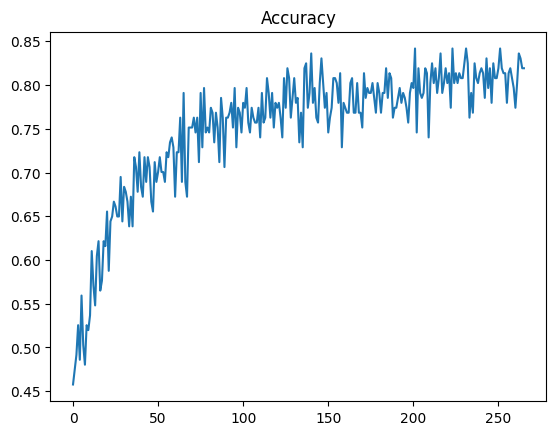

Average accuracy train:  0.8590004020398232
Average accuracy valid:  0.7746700890007872
Average accuracy test:  0.8158551810237203


In [59]:
train_accuracy = []
valid_accuracy = []
test_accuracy = []

print(X_valid.shape)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)
    
test_batch = DataLoader(list(zip(X_test_tensor,y_test_tensor)), batch_size=32, shuffle=False)

for train_index,valid_index in KFold(9).split(X):
    
    X_train,X_valid=X.iloc[train_index],X.iloc[valid_index]
    y_train,y_valid=y.iloc[train_index],y.iloc[valid_index]
    
    print(X_train.shape)
    print(X_valid.shape)
    
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    
    valid_batch = DataLoader(list(zip(X_train_tensor,y_train_tensor)), batch_size=32, shuffle=False)
    
    X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
    y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).reshape(-1, 1)
    
    train_batch = DataLoader(list(zip(X_valid_tensor,y_valid_tensor)), batch_size=16, shuffle=False)
    
    model = MLP(7)
    
    acc, model = model_train(model, train_batch, 1000, 64, "pycharm_current_model.pt")
    
    train_accuracy.append(acc)
    
    model.eval()
    
    valid_accuracy.append(evaluate_model(model, valid_batch))
    
    test_accuracy.append(evaluate_model(model, test_batch))

print("Average accuracy train: ", np.mean(train_accuracy))
print("Average accuracy valid: ", np.mean(valid_accuracy))
print("Average accuracy test: ", np.mean(test_accuracy))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=89bb4cc5-edcf-4173-a34d-8a1b6ba083ed' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>